## Инициализация

In [2]:
import numpy as np
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
SEED = 777

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

device

'cuda'

## Dataset

In [4]:
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-05-31 17:49:40--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  9.31MB/s    in 15s     

2024-05-31 17:49:55 (11.4 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-05-31 17:49:55--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  9.02MB/s    in 6.4s    

2024-05-31 17:50:02 (9.52 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2024-05-31 17:50:02--
Total wall clock time: 22s
Downloaded: 2 files, 235M in

In [5]:
import scipy.io
from sklearn.model_selection import train_test_split

train_data = scipy.io.loadmat('./train_32x32.mat')
test_data = scipy.io.loadmat('./test_32x32.mat')

X_train, y_train, X_test, y_test = train_data['X'], train_data['y'], test_data['X'], test_data['y']
X_train, y_train, X_test, y_test = np.moveaxis(X_train, -1, 0), y_train.flatten(), np.moveaxis(X_test, -1, 0), y_test.flatten()
y_train[y_train == 10], y_test[y_test == 10] = 0, 0
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

print(f'Train data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (58605, 32, 32, 3)
Validation data shape: (14652, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


In [6]:
import albumentations
from albumentations.pytorch import ToTensorV2

IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32

transform = albumentations.Compose(
    [
        albumentations.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [7]:
from torch.utils.data import Dataset, DataLoader


class SVHNDataset(Dataset):
    def __init__(self, images, classes, transform=None):
        self.transform = transform
        self.images = images
        self.classes = classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(self.images[idx])

        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, self.classes[idx]


def get_loader(images, classes, transform, batch_size):
    dataset = SVHNDataset(images=images, classes=classes, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)

In [8]:
batch_size = 8

train_data_loader = get_loader(X_train, y_train, transform, batch_size)
val_data_loader = get_loader(X_val, y_val, transform, batch_size)
test_data_loader = get_loader(X_test, y_test, transform, batch_size)

## Custom layers

In [9]:
import math

class FullyConnectedLayer(torch.nn.Module):
    def __init__(self, _input, _output, bias=True):
        super().__init__()
        self.in_features = _input
        self.out_features = _input

        self.weight = torch.nn.Parameter(torch.Tensor(_output, _input))
        self.bias = bias
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(_output))
        else:
            self.register_parameter('bias', None)

        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        output = input.matmul(self.weight.t())
        if self.bias is not None:
            output += self.bias

        return output

In [10]:
class ReLULayer(torch.nn.Module):
    def __init__(self):
        super(ReLULayer, self).__init__()

    def forward(self, x):
        return torch.max(torch.zeros_like(x), x)

In [11]:
from collections import OrderedDict


class CustomNN(torch.nn.Module):
    def __init__(self, _input_size, hidden_size, _output_size, bn=False):
        super(CustomNN, self).__init__()
        self.model = torch.nn.Sequential(OrderedDict([
            ('fc1', FullyConnectedLayer(_input_size, hidden_size)),
            ('relu', ReLULayer()),
            ('fc2', FullyConnectedLayer(hidden_size, _output_size))
        ]))


    def forward(self, x):
        return self.model(x)

## Основные функции для обучения

In [12]:
def check_gradients(nn_model, input_data, labels, loss_fn, eps=1e-5, num_params_to_check=10):
    input_data = input_data.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3).to(device)
    labels = labels.to(device)
    nn_model.zero_grad()
    loss = loss_fn(nn_model(input_data), labels)
    loss.backward()

    params = list(nn_model.named_parameters())
    total_params = sum(p[1].nelement() for p in params if p[1].requires_grad)
    num_params_to_check = min(num_params_to_check, total_params)
    random_indices = torch.randperm(total_params)[:num_params_to_check]

    for name, param in params:
        if param.requires_grad:
            print(f"Validating gradient for: {name}")

            grad = param.grad
            flat_param = param.data.view(-1)
            flat_grad = grad.view(-1)

            for index in random_indices:
                if index >= flat_param.size(0):
                    continue

                flat_param[index] += eps
                loss_increased = loss_fn(nn_model(input_data), labels)
                flat_param[index] -= 2 * eps
                loss_decreased = loss_fn(nn_model(input_data), labels)
                flat_param[index] += eps

                estimated_grad = (loss_increased - loss_decreased) / (2 * eps)
                grad_diff = torch.abs(estimated_grad - flat_grad[index]).item()
                if grad_diff > eps:
                    print(f'Gradient check failed for {name} at index {index}')
                    return False

    print('Gradient check passed successfully!')
    return True

In [13]:
def train(nn_model, train_loader, val_loader, opt, epochs, lr, decay, results_df):
    loss_fn = torch.nn.CrossEntropyLoss().to(device)
    opt = opt(nn_model.parameters(), lr=lr, weight_decay=decay)

    train_losses = []
    val_losses = []
    max_accuracy = 0

    for epoch in range(epochs):
        nn_model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader):
            images = images.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3).to(device)
            labels = labels.to(device)

            opt.zero_grad()
            out = nn_model(images)
            loss = loss_fn(out, labels)
            loss.backward()
            opt.step()

            total_loss += loss.item()
            _, preds = torch.max(out, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = correct / total

        val_loss, val_correct, val_total = evaluate_model(nn_model, val_loader, loss_fn)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = val_correct / val_total

        max_accuracy = max(max_accuracy, val_acc)

        print_epoch_stats(epoch + 1, epochs, avg_train_loss, train_acc, avg_val_loss, val_acc)

        check_gradients(nn_model, *next(iter(train_loader)), loss_fn)

    return train_losses, val_losses, update_results(results_df, opt, lr, decay, max_accuracy)

def evaluate_model(model, data_loader, loss_fn=None):
    model.eval()
    loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3).to(device), labels.to(device)
            outputs = model(images)
            if loss_fn is not None:
                loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return loss, correct, total

def print_epoch_stats(epoch, total_epochs, train_loss, train_acc, val_loss, val_acc):
    print(f'\nEpoch [{epoch}/{total_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%')

def update_results(df, optimizer, learning_rate, weight_decay, best_accuracy):
    new_data = {
        "optimizer": [str(optimizer).split('(')[0].strip()],
        "learning_rate": [learning_rate],
        "weight_decay": [weight_decay],
        "val_accuracy": [best_accuracy]
    }
    return pd.concat([df, pd.DataFrame(new_data)])


In [14]:
from tqdm import tqdm
import torch.optim as optim


def train_grid_search(results, num_epochs, learning_rates, weight_decays):
    optimizer = optim.RMSprop

    for lr in learning_rates:
        for wd in weight_decays:
            model = CustomNN(_input_size=IMAGE_HEIGHT*IMAGE_WIDTH*3, hidden_size=256, _output_size=10).to(device)

            print(f"Training with {lr=}, {wd=}, {optimizer=}")
            train_losses, val_losses, results = train(model, train_data_loader, val_data_loader, optimizer, num_epochs, lr, wd, results)

            _, correct, total = evaluate_model(model, test_data_loader)
            accuracy = correct / total
            print(f"Test Accuracy with learning rate {lr} and weight_decay {wd}: {100 * accuracy:.2f}%")

            plt.plot(range(num_epochs), train_losses, label='Train Loss')
            plt.plot(range(num_epochs), val_losses, label='Val Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Train/Val Losses')
            plt.legend()
            plt.show()

    return results

## Обучение

Обучим нейронную сеть с подбором параметров на 10 эпохах

In [19]:
results = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'val_accuracy'])

Training with lr=0.01, wd=0.01, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:07<00:00, 248.26it/s]


Epoch [1/10], Train Loss: 2.8124, Train Acc: 18.83%, Val Loss: 2.2398, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 338.12it/s]


Epoch [2/10], Train Loss: 2.2385, Train Acc: 18.87%, Val Loss: 2.2415, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 304.17it/s]


Epoch [3/10], Train Loss: 2.2388, Train Acc: 18.89%, Val Loss: 2.2400, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 247.26it/s]


Epoch [4/10], Train Loss: 2.2387, Train Acc: 18.88%, Val Loss: 2.2386, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 240.69it/s]


Epoch [5/10], Train Loss: 2.2387, Train Acc: 18.89%, Val Loss: 2.2474, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 249.98it/s]


Epoch [6/10], Train Loss: 2.2391, Train Acc: 18.89%, Val Loss: 2.2404, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 333.63it/s]


Epoch [7/10], Train Loss: 2.2390, Train Acc: 18.90%, Val Loss: 2.2401, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 325.01it/s]


Epoch [8/10], Train Loss: 2.2389, Train Acc: 18.89%, Val Loss: 2.2410, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 249.14it/s]


Epoch [9/10], Train Loss: 2.2390, Train Acc: 18.89%, Val Loss: 2.2409, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 303.20it/s]


Epoch [10/10], Train Loss: 2.2388, Train Acc: 18.89%, Val Loss: 2.2431, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 3254/3254 [00:10<00:00, 318.69it/s]


Test Accuracy with learning rate 0.01 and weight_decay 0.01: 19.59%


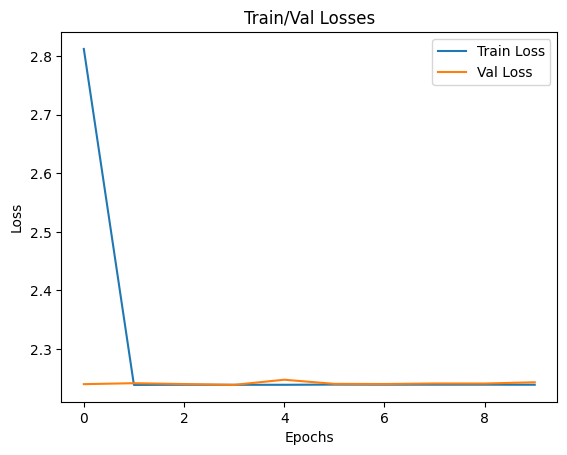

Training with lr=0.01, wd=0.001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:06<00:00, 272.97it/s]


Epoch [1/10], Train Loss: 2.7740, Train Acc: 18.84%, Val Loss: 2.2417, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 251.00it/s]


Epoch [2/10], Train Loss: 2.2386, Train Acc: 18.91%, Val Loss: 2.2389, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 327.71it/s]


Epoch [3/10], Train Loss: 2.2386, Train Acc: 18.91%, Val Loss: 2.2406, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 347.20it/s]


Epoch [4/10], Train Loss: 2.2386, Train Acc: 18.90%, Val Loss: 2.2419, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 267.07it/s]


Epoch [5/10], Train Loss: 2.2385, Train Acc: 18.88%, Val Loss: 2.2453, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 332.36it/s]


Epoch [6/10], Train Loss: 2.2388, Train Acc: 18.89%, Val Loss: 2.2405, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 341888


100%|██████████| 1832/1832 [00:05<00:00, 346.19it/s]


Epoch [7/10], Train Loss: 2.2387, Train Acc: 18.90%, Val Loss: 2.2421, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 259.69it/s]


Epoch [8/10], Train Loss: 2.2387, Train Acc: 18.90%, Val Loss: 2.2420, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 319.26it/s]


Epoch [9/10], Train Loss: 2.2388, Train Acc: 18.90%, Val Loss: 2.2405, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 337.34it/s]


Epoch [10/10], Train Loss: 2.2384, Train Acc: 18.91%, Val Loss: 2.2412, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 3254/3254 [00:10<00:00, 298.46it/s]


Test Accuracy with learning rate 0.01 and weight_decay 0.001: 19.59%


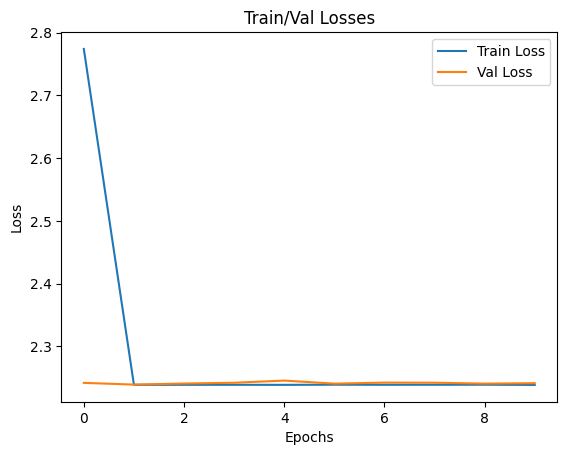

Training with lr=0.01, wd=0.0001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:07<00:00, 257.08it/s]



Epoch [1/10], Train Loss: 2.7566, Train Acc: 18.83%, Val Loss: 2.2392, Val Acc: 18.95%
Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 337.35it/s]


Epoch [2/10], Train Loss: 2.2411, Train Acc: 18.90%, Val Loss: 2.2407, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 338.54it/s]


Epoch [3/10], Train Loss: 2.2386, Train Acc: 18.91%, Val Loss: 2.2403, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 271.78it/s]


Epoch [4/10], Train Loss: 2.2387, Train Acc: 18.90%, Val Loss: 2.2419, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 265.40it/s]


Epoch [5/10], Train Loss: 2.2388, Train Acc: 18.90%, Val Loss: 2.2397, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 349.07it/s]


Epoch [6/10], Train Loss: 2.2389, Train Acc: 18.89%, Val Loss: 2.2389, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 340.16it/s]


Epoch [7/10], Train Loss: 2.2388, Train Acc: 18.91%, Val Loss: 2.2429, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 250.09it/s]


Epoch [8/10], Train Loss: 2.2384, Train Acc: 18.88%, Val Loss: 2.2427, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 342.35it/s]


Epoch [9/10], Train Loss: 2.2386, Train Acc: 18.91%, Val Loss: 2.2398, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 275.08it/s]


Epoch [10/10], Train Loss: 2.2383, Train Acc: 18.89%, Val Loss: 2.2400, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 326636


100%|██████████| 3254/3254 [00:10<00:00, 313.36it/s]


Test Accuracy with learning rate 0.01 and weight_decay 0.0001: 19.59%


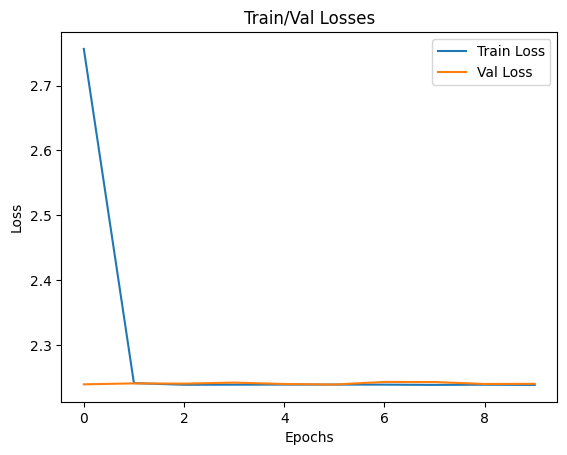

Training with lr=0.001, wd=0.01, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:05<00:00, 344.10it/s]


Epoch [1/10], Train Loss: 2.2566, Train Acc: 18.75%, Val Loss: 2.2388, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 320.33it/s]


Epoch [2/10], Train Loss: 2.2369, Train Acc: 18.91%, Val Loss: 2.2383, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 254.75it/s]


Epoch [3/10], Train Loss: 2.2367, Train Acc: 18.91%, Val Loss: 2.2385, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 287.29it/s]


Epoch [4/10], Train Loss: 2.2368, Train Acc: 18.91%, Val Loss: 2.2384, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 338.82it/s]


Epoch [5/10], Train Loss: 2.2367, Train Acc: 18.91%, Val Loss: 2.2386, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 334.06it/s]


Epoch [6/10], Train Loss: 2.2368, Train Acc: 18.91%, Val Loss: 2.2386, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 239.45it/s]


Epoch [7/10], Train Loss: 2.2367, Train Acc: 18.91%, Val Loss: 2.2386, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 302.46it/s]


Epoch [8/10], Train Loss: 2.2368, Train Acc: 18.91%, Val Loss: 2.2384, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 334.60it/s]


Epoch [9/10], Train Loss: 2.2367, Train Acc: 18.91%, Val Loss: 2.2385, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 251.72it/s]


Epoch [10/10], Train Loss: 2.2368, Train Acc: 18.91%, Val Loss: 2.2385, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 3254/3254 [00:11<00:00, 288.73it/s]


Test Accuracy with learning rate 0.001 and weight_decay 0.01: 19.59%


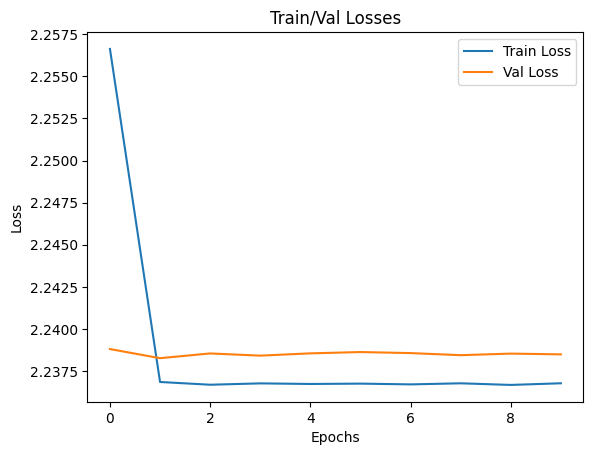

Training with lr=0.001, wd=0.001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:05<00:00, 336.13it/s]


Epoch [1/10], Train Loss: 2.2590, Train Acc: 18.59%, Val Loss: 2.2093, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 319.57it/s]


Epoch [2/10], Train Loss: 2.1832, Train Acc: 19.03%, Val Loss: 2.1640, Val Acc: 19.77%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 247.21it/s]


Epoch [3/10], Train Loss: 2.1686, Train Acc: 19.55%, Val Loss: 2.1650, Val Acc: 19.52%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 288.92it/s]


Epoch [4/10], Train Loss: 2.1691, Train Acc: 19.42%, Val Loss: 2.1640, Val Acc: 19.55%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 335.49it/s]


Epoch [5/10], Train Loss: 2.1684, Train Acc: 19.47%, Val Loss: 2.1753, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 312.76it/s]


Epoch [6/10], Train Loss: 2.1669, Train Acc: 19.41%, Val Loss: 2.1545, Val Acc: 19.88%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 243.26it/s]


Epoch [7/10], Train Loss: 2.1673, Train Acc: 19.33%, Val Loss: 2.1656, Val Acc: 19.26%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 270.11it/s]


Epoch [8/10], Train Loss: 2.1662, Train Acc: 19.47%, Val Loss: 2.1595, Val Acc: 19.92%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 299.92it/s]


Epoch [9/10], Train Loss: 2.1669, Train Acc: 19.42%, Val Loss: 2.1534, Val Acc: 20.00%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 289443


100%|██████████| 1832/1832 [00:05<00:00, 323.22it/s]


Epoch [10/10], Train Loss: 2.1678, Train Acc: 19.37%, Val Loss: 2.1545, Val Acc: 19.98%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 3254/3254 [00:11<00:00, 288.76it/s]


Test Accuracy with learning rate 0.001 and weight_decay 0.001: 20.62%


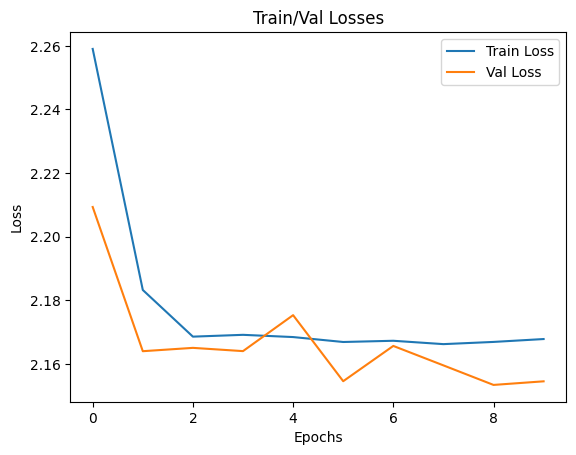

Training with lr=0.001, wd=0.0001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:07<00:00, 246.56it/s]


Epoch [1/10], Train Loss: 2.2425, Train Acc: 18.72%, Val Loss: 2.1830, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 288.61it/s]


Epoch [2/10], Train Loss: 2.1744, Train Acc: 19.31%, Val Loss: 2.1709, Val Acc: 19.71%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 334.37it/s]


Epoch [3/10], Train Loss: 2.1661, Train Acc: 19.60%, Val Loss: 2.1793, Val Acc: 18.61%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 310.11it/s]


Epoch [4/10], Train Loss: 2.1641, Train Acc: 19.51%, Val Loss: 2.1643, Val Acc: 19.29%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 256.49it/s]


Epoch [5/10], Train Loss: 2.1641, Train Acc: 19.31%, Val Loss: 2.1532, Val Acc: 19.84%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 272.59it/s]


Epoch [6/10], Train Loss: 2.1640, Train Acc: 19.43%, Val Loss: 2.1746, Val Acc: 18.60%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 331.69it/s]


Epoch [7/10], Train Loss: 2.1631, Train Acc: 19.54%, Val Loss: 2.1530, Val Acc: 19.77%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 332.03it/s]


Epoch [8/10], Train Loss: 2.1631, Train Acc: 19.51%, Val Loss: 2.1831, Val Acc: 18.95%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 242.03it/s]


Epoch [9/10], Train Loss: 2.1627, Train Acc: 19.36%, Val Loss: 2.1691, Val Acc: 18.88%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 286.64it/s]


Epoch [10/10], Train Loss: 2.1623, Train Acc: 19.38%, Val Loss: 2.1514, Val Acc: 19.81%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 3254/3254 [00:09<00:00, 327.13it/s]


Test Accuracy with learning rate 0.001 and weight_decay 0.0001: 20.96%


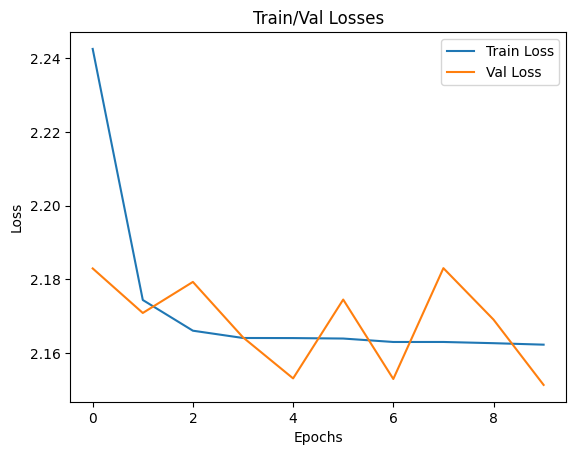

Training with lr=0.0001, wd=0.01, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:05<00:00, 323.49it/s]


Epoch [1/10], Train Loss: 2.2303, Train Acc: 19.38%, Val Loss: 2.1787, Val Acc: 21.81%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 29328


100%|██████████| 1832/1832 [00:07<00:00, 248.05it/s]


Epoch [2/10], Train Loss: 2.0793, Train Acc: 25.87%, Val Loss: 1.9797, Val Acc: 30.79%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 285.48it/s]


Epoch [3/10], Train Loss: 1.8953, Train Acc: 34.49%, Val Loss: 1.8294, Val Acc: 35.79%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 326.57it/s]


Epoch [4/10], Train Loss: 1.7473, Train Acc: 41.14%, Val Loss: 1.7105, Val Acc: 44.00%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 312064


100%|██████████| 1832/1832 [00:05<00:00, 327.87it/s]


Epoch [5/10], Train Loss: 1.6543, Train Acc: 44.63%, Val Loss: 1.6184, Val Acc: 46.34%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 304477


100%|██████████| 1832/1832 [00:07<00:00, 247.04it/s]


Epoch [6/10], Train Loss: 1.5978, Train Acc: 46.92%, Val Loss: 1.5659, Val Acc: 49.63%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 717205


100%|██████████| 1832/1832 [00:05<00:00, 334.95it/s]


Epoch [7/10], Train Loss: 1.5588, Train Acc: 48.61%, Val Loss: 1.5786, Val Acc: 47.67%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 328.48it/s]


Epoch [8/10], Train Loss: 1.5282, Train Acc: 49.90%, Val Loss: 1.5237, Val Acc: 49.52%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 312.87it/s]


Epoch [9/10], Train Loss: 1.5037, Train Acc: 50.99%, Val Loss: 1.5571, Val Acc: 48.70%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 468342


100%|██████████| 1832/1832 [00:07<00:00, 247.86it/s]


Epoch [10/10], Train Loss: 1.4816, Train Acc: 52.16%, Val Loss: 1.5218, Val Acc: 51.40%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 3254/3254 [00:10<00:00, 316.91it/s]


Test Accuracy with learning rate 0.0001 and weight_decay 0.01: 48.35%


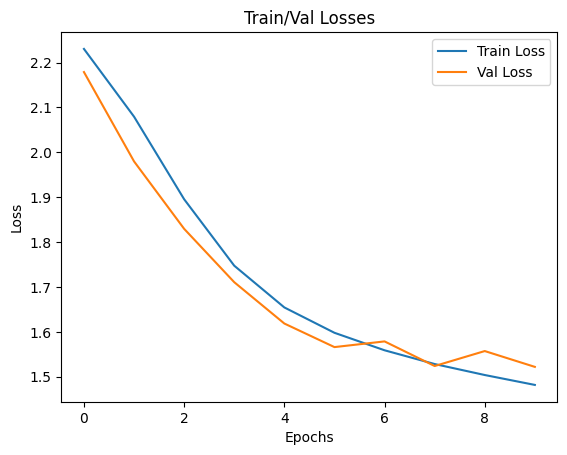

Training with lr=0.0001, wd=0.001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:05<00:00, 330.13it/s]


Epoch [1/10], Train Loss: 2.2266, Train Acc: 19.85%, Val Loss: 2.1677, Val Acc: 23.05%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 190251


100%|██████████| 1832/1832 [00:05<00:00, 320.35it/s]


Epoch [2/10], Train Loss: 2.0381, Train Acc: 27.58%, Val Loss: 1.9106, Val Acc: 36.06%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 250.77it/s]


Epoch [3/10], Train Loss: 1.7809, Train Acc: 39.66%, Val Loss: 1.6704, Val Acc: 44.87%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 302.36it/s]


Epoch [4/10], Train Loss: 1.5985, Train Acc: 47.53%, Val Loss: 1.5606, Val Acc: 48.67%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 179770


100%|██████████| 1832/1832 [00:06<00:00, 304.60it/s]


Epoch [5/10], Train Loss: 1.4864, Train Acc: 52.14%, Val Loss: 1.4726, Val Acc: 51.46%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 304.15it/s]


Epoch [6/10], Train Loss: 1.4095, Train Acc: 55.53%, Val Loss: 1.3849, Val Acc: 56.98%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 591750


100%|██████████| 1832/1832 [00:07<00:00, 248.11it/s]


Epoch [7/10], Train Loss: 1.3516, Train Acc: 57.76%, Val Loss: 1.3240, Val Acc: 59.43%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 59025


100%|██████████| 1832/1832 [00:07<00:00, 255.21it/s]


Epoch [8/10], Train Loss: 1.3072, Train Acc: 59.19%, Val Loss: 1.3043, Val Acc: 58.88%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 475728


100%|██████████| 1832/1832 [00:06<00:00, 290.94it/s]


Epoch [9/10], Train Loss: 1.2710, Train Acc: 60.70%, Val Loss: 1.2446, Val Acc: 63.03%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 533778


100%|██████████| 1832/1832 [00:06<00:00, 301.64it/s]


Epoch [10/10], Train Loss: 1.2371, Train Acc: 62.07%, Val Loss: 1.2561, Val Acc: 61.45%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 3254/3254 [00:11<00:00, 276.35it/s]


Test Accuracy with learning rate 0.0001 and weight_decay 0.001: 57.35%


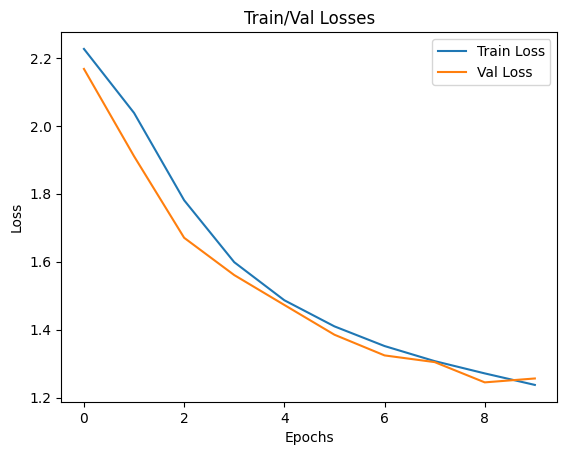

Training with lr=0.0001, wd=0.0001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:06<00:00, 297.54it/s]


Epoch [1/10], Train Loss: 2.2030, Train Acc: 20.88%, Val Loss: 2.0915, Val Acc: 26.86%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 177224


100%|██████████| 1832/1832 [00:07<00:00, 247.18it/s]


Epoch [2/10], Train Loss: 1.9044, Train Acc: 34.11%, Val Loss: 1.7431, Val Acc: 41.11%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 293940


100%|██████████| 1832/1832 [00:06<00:00, 281.35it/s]


Epoch [3/10], Train Loss: 1.6351, Train Acc: 46.11%, Val Loss: 1.5488, Val Acc: 49.28%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 67109


100%|██████████| 1832/1832 [00:05<00:00, 327.28it/s]


Epoch [4/10], Train Loss: 1.4725, Train Acc: 53.02%, Val Loss: 1.4274, Val Acc: 55.86%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 325.87it/s]


Epoch [5/10], Train Loss: 1.3638, Train Acc: 57.19%, Val Loss: 1.3214, Val Acc: 58.03%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:07<00:00, 259.15it/s]


Epoch [6/10], Train Loss: 1.2849, Train Acc: 60.32%, Val Loss: 1.2759, Val Acc: 60.39%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 509901


100%|██████████| 1832/1832 [00:06<00:00, 262.81it/s]


Epoch [7/10], Train Loss: 1.2250, Train Acc: 62.46%, Val Loss: 1.1995, Val Acc: 64.11%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 696414


100%|██████████| 1832/1832 [00:06<00:00, 295.88it/s]


Epoch [8/10], Train Loss: 1.1797, Train Acc: 64.13%, Val Loss: 1.1531, Val Acc: 65.66%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 568903


100%|██████████| 1832/1832 [00:05<00:00, 327.63it/s]


Epoch [9/10], Train Loss: 1.1434, Train Acc: 65.35%, Val Loss: 1.1321, Val Acc: 66.53%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 325.81it/s]


Epoch [10/10], Train Loss: 1.1135, Train Acc: 66.31%, Val Loss: 1.0999, Val Acc: 68.09%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 81345


100%|██████████| 3254/3254 [00:11<00:00, 290.12it/s]


Test Accuracy with learning rate 0.0001 and weight_decay 0.0001: 63.22%


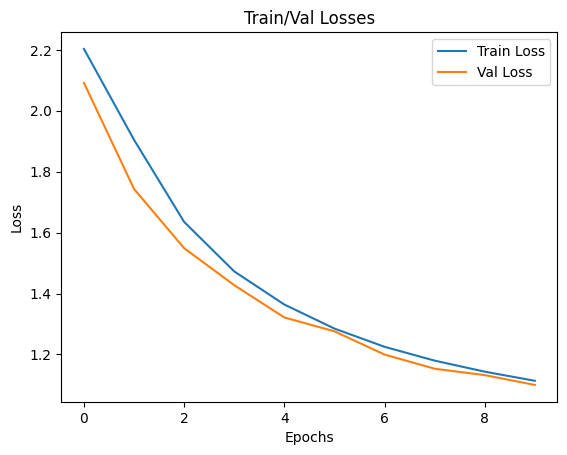

,optimizer,learning_rate,weight_decay,val_accuracy
0,RMSprop,0.0100,0.0100,0.189530
0,RMSprop,0.0100,0.0010,0.189530
0,RMSprop,0.0100,0.0001,0.189530
0,RMSprop,0.0010,0.0100,0.189530
0,RMSprop,0.0010,0.0010,0.199973
0,RMSprop,0.0010,0.0001,0.198403
0,RMSprop,0.0001,0.0100,0.513991
0,RMSprop,0.0001,0.0010,0.630289
0,RMSprop,0.0001,0.0001,0.680863


In [20]:
train_grid_search(results, 10, [0.01, 0.001, 0.0001], [0.01, 0.001, 0.0001])

## Fine-tuning

Переобучим модель с 3 лучшими наборами параметров на 50 эпохах

In [15]:
results = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'val_accuracy'])

Training with lr=0.0001, wd=0.01, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:07<00:00, 261.36it/s]


Epoch [1/50], Train Loss: 2.2304, Train Acc: 18.90%, Val Loss: 2.1803, Val Acc: 20.64%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 685256


100%|██████████| 1832/1832 [00:06<00:00, 279.23it/s]


Epoch [2/50], Train Loss: 2.0856, Train Acc: 25.36%, Val Loss: 1.9981, Val Acc: 32.14%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 334.84it/s]


Epoch [3/50], Train Loss: 1.9098, Train Acc: 33.53%, Val Loss: 1.8254, Val Acc: 38.80%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 315.08it/s]


Epoch [4/50], Train Loss: 1.7780, Train Acc: 40.27%, Val Loss: 1.7162, Val Acc: 43.73%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 42678


100%|██████████| 1832/1832 [00:06<00:00, 280.96it/s]


Epoch [5/50], Train Loss: 1.6914, Train Acc: 44.07%, Val Loss: 1.6602, Val Acc: 45.44%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 327.94it/s]


Epoch [6/50], Train Loss: 1.6272, Train Acc: 47.12%, Val Loss: 1.5977, Val Acc: 48.39%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 69807


100%|██████████| 1832/1832 [00:06<00:00, 283.26it/s]


Epoch [7/50], Train Loss: 1.5754, Train Acc: 49.54%, Val Loss: 1.5442, Val Acc: 51.88%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 20798


100%|██████████| 1832/1832 [00:05<00:00, 356.15it/s]


Epoch [8/50], Train Loss: 1.5239, Train Acc: 51.65%, Val Loss: 1.5121, Val Acc: 52.18%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 77832


100%|██████████| 1832/1832 [00:05<00:00, 333.64it/s]


Epoch [9/50], Train Loss: 1.4836, Train Acc: 53.27%, Val Loss: 1.5288, Val Acc: 50.61%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 280458


100%|██████████| 1832/1832 [00:06<00:00, 268.90it/s]


Epoch [10/50], Train Loss: 1.4519, Train Acc: 54.25%, Val Loss: 1.4450, Val Acc: 55.42%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 70476


100%|██████████| 1832/1832 [00:05<00:00, 353.00it/s]


Epoch [11/50], Train Loss: 1.4251, Train Acc: 55.57%, Val Loss: 1.4027, Val Acc: 56.78%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 77615


100%|██████████| 1832/1832 [00:08<00:00, 225.16it/s]


Epoch [12/50], Train Loss: 1.4037, Train Acc: 56.29%, Val Loss: 1.4029, Val Acc: 56.60%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 304.77it/s]


Epoch [13/50], Train Loss: 1.3845, Train Acc: 57.14%, Val Loss: 1.3761, Val Acc: 58.33%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 352.33it/s]


Epoch [14/50], Train Loss: 1.3677, Train Acc: 57.74%, Val Loss: 1.3569, Val Acc: 60.09%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 267.84it/s]


Epoch [15/50], Train Loss: 1.3537, Train Acc: 58.50%, Val Loss: 1.3673, Val Acc: 57.25%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 365.21it/s]


Epoch [16/50], Train Loss: 1.3427, Train Acc: 58.85%, Val Loss: 1.3621, Val Acc: 58.01%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 345.73it/s]


Epoch [17/50], Train Loss: 1.3330, Train Acc: 59.52%, Val Loss: 1.3406, Val Acc: 59.94%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:08<00:00, 224.56it/s]


Epoch [18/50], Train Loss: 1.3247, Train Acc: 59.74%, Val Loss: 1.3852, Val Acc: 55.16%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 205262


100%|██████████| 1832/1832 [00:05<00:00, 357.08it/s]


Epoch [19/50], Train Loss: 1.3174, Train Acc: 60.14%, Val Loss: 1.3244, Val Acc: 60.53%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 591045


100%|██████████| 1832/1832 [00:06<00:00, 269.92it/s]


Epoch [20/50], Train Loss: 1.3115, Train Acc: 60.38%, Val Loss: 1.3308, Val Acc: 59.59%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 204693


100%|██████████| 1832/1832 [00:05<00:00, 359.82it/s]


Epoch [21/50], Train Loss: 1.3051, Train Acc: 60.70%, Val Loss: 1.3181, Val Acc: 60.33%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 69805


100%|██████████| 1832/1832 [00:06<00:00, 276.33it/s]


Epoch [22/50], Train Loss: 1.3009, Train Acc: 60.81%, Val Loss: 1.3054, Val Acc: 61.34%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 350.46it/s]


Epoch [23/50], Train Loss: 1.2980, Train Acc: 60.90%, Val Loss: 1.3240, Val Acc: 59.34%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 285.89it/s]


Epoch [24/50], Train Loss: 1.2936, Train Acc: 61.15%, Val Loss: 1.2994, Val Acc: 61.39%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 365566


100%|██████████| 1832/1832 [00:06<00:00, 274.26it/s]


Epoch [25/50], Train Loss: 1.2895, Train Acc: 61.26%, Val Loss: 1.2998, Val Acc: 62.75%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 70412


100%|██████████| 1832/1832 [00:05<00:00, 347.60it/s]


Epoch [26/50], Train Loss: 1.2871, Train Acc: 61.40%, Val Loss: 1.2864, Val Acc: 62.27%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 209099


100%|██████████| 1832/1832 [00:05<00:00, 341.38it/s]


Epoch [27/50], Train Loss: 1.2841, Train Acc: 61.43%, Val Loss: 1.2877, Val Acc: 62.09%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 299.20it/s]


Epoch [28/50], Train Loss: 1.2835, Train Acc: 61.47%, Val Loss: 1.3306, Val Acc: 58.80%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 209103


100%|██████████| 1832/1832 [00:05<00:00, 359.71it/s]


Epoch [29/50], Train Loss: 1.2806, Train Acc: 61.63%, Val Loss: 1.2865, Val Acc: 62.80%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 382006


100%|██████████| 1832/1832 [00:05<00:00, 344.87it/s]


Epoch [30/50], Train Loss: 1.2790, Train Acc: 61.63%, Val Loss: 1.3142, Val Acc: 59.97%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 288.71it/s]


Epoch [31/50], Train Loss: 1.2773, Train Acc: 61.79%, Val Loss: 1.2723, Val Acc: 63.07%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 685576


100%|██████████| 1832/1832 [00:05<00:00, 356.03it/s]


Epoch [32/50], Train Loss: 1.2777, Train Acc: 61.60%, Val Loss: 1.2834, Val Acc: 62.39%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 273.02it/s]


Epoch [33/50], Train Loss: 1.2758, Train Acc: 61.82%, Val Loss: 1.2794, Val Acc: 61.83%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 325410


100%|██████████| 1832/1832 [00:05<00:00, 326.40it/s]


Epoch [34/50], Train Loss: 1.2750, Train Acc: 61.79%, Val Loss: 1.2656, Val Acc: 63.35%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 68255


100%|██████████| 1832/1832 [00:05<00:00, 346.27it/s]


Epoch [35/50], Train Loss: 1.2728, Train Acc: 61.84%, Val Loss: 1.2725, Val Acc: 61.68%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 323619


100%|██████████| 1832/1832 [00:07<00:00, 259.67it/s]


Epoch [36/50], Train Loss: 1.2731, Train Acc: 61.77%, Val Loss: 1.2773, Val Acc: 62.22%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 326.59it/s]


Epoch [37/50], Train Loss: 1.2715, Train Acc: 61.91%, Val Loss: 1.3434, Val Acc: 58.67%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 284.31it/s]


Epoch [38/50], Train Loss: 1.2695, Train Acc: 61.96%, Val Loss: 1.2796, Val Acc: 61.68%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 203580


100%|██████████| 1832/1832 [00:05<00:00, 354.50it/s]


Epoch [39/50], Train Loss: 1.2694, Train Acc: 62.08%, Val Loss: 1.3096, Val Acc: 58.76%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 209728


100%|██████████| 1832/1832 [00:06<00:00, 291.54it/s]


Epoch [40/50], Train Loss: 1.2683, Train Acc: 62.06%, Val Loss: 1.2845, Val Acc: 60.66%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 686327


100%|██████████| 1832/1832 [00:06<00:00, 283.52it/s]


Epoch [41/50], Train Loss: 1.2676, Train Acc: 62.12%, Val Loss: 1.3156, Val Acc: 58.84%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 279728


100%|██████████| 1832/1832 [00:06<00:00, 276.20it/s]


Epoch [42/50], Train Loss: 1.2674, Train Acc: 62.06%, Val Loss: 1.2992, Val Acc: 61.08%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:11<00:00, 156.11it/s]


Epoch [43/50], Train Loss: 1.2674, Train Acc: 62.31%, Val Loss: 1.3103, Val Acc: 61.24%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 265.27it/s]


Epoch [44/50], Train Loss: 1.2669, Train Acc: 62.24%, Val Loss: 1.2733, Val Acc: 62.37%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 348.30it/s]


Epoch [45/50], Train Loss: 1.2665, Train Acc: 62.22%, Val Loss: 1.2596, Val Acc: 62.83%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 342.48it/s]


Epoch [46/50], Train Loss: 1.2666, Train Acc: 62.19%, Val Loss: 1.3008, Val Acc: 61.68%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Gradient check failed for model.fc2.weight at index 580


100%|██████████| 1832/1832 [00:06<00:00, 265.70it/s]


Epoch [47/50], Train Loss: 1.2651, Train Acc: 62.10%, Val Loss: 1.2981, Val Acc: 61.88%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 560170


100%|██████████| 1832/1832 [00:05<00:00, 357.55it/s]


Epoch [48/50], Train Loss: 1.2649, Train Acc: 62.33%, Val Loss: 1.2714, Val Acc: 62.88%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 362603


100%|██████████| 1832/1832 [00:06<00:00, 284.33it/s]


Epoch [49/50], Train Loss: 1.2658, Train Acc: 62.29%, Val Loss: 1.3143, Val Acc: 59.21%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 80240


100%|██████████| 1832/1832 [00:05<00:00, 344.63it/s]


Epoch [50/50], Train Loss: 1.2637, Train Acc: 62.39%, Val Loss: 1.2689, Val Acc: 62.20%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 3254/3254 [00:10<00:00, 301.04it/s]


Test Accuracy with learning rate 0.0001 and weight_decay 0.01: 59.19%


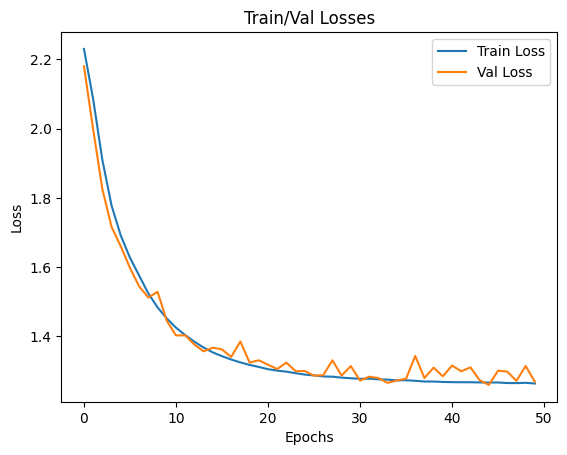

Training with lr=0.0001, wd=0.001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:06<00:00, 280.13it/s]


Epoch [1/50], Train Loss: 2.2007, Train Acc: 19.79%, Val Loss: 2.1007, Val Acc: 22.90%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 275118


100%|██████████| 1832/1832 [00:05<00:00, 350.62it/s]


Epoch [2/50], Train Loss: 1.9658, Train Acc: 29.99%, Val Loss: 1.8779, Val Acc: 32.70%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 334.61it/s]


Epoch [3/50], Train Loss: 1.7333, Train Acc: 41.35%, Val Loss: 1.6395, Val Acc: 46.69%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 279.75it/s]


Epoch [4/50], Train Loss: 1.5695, Train Acc: 48.99%, Val Loss: 1.5071, Val Acc: 51.17%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 350.02it/s]


Epoch [5/50], Train Loss: 1.4476, Train Acc: 53.69%, Val Loss: 1.3980, Val Acc: 56.87%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 293.76it/s]


Epoch [6/50], Train Loss: 1.3615, Train Acc: 57.04%, Val Loss: 1.3556, Val Acc: 58.09%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 328.83it/s]


Epoch [7/50], Train Loss: 1.2988, Train Acc: 59.45%, Val Loss: 1.2684, Val Acc: 61.43%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 342.65it/s]


Epoch [8/50], Train Loss: 1.2480, Train Acc: 61.40%, Val Loss: 1.2600, Val Acc: 60.53%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 277.72it/s]


Epoch [9/50], Train Loss: 1.2077, Train Acc: 63.07%, Val Loss: 1.1874, Val Acc: 64.26%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 341.00it/s]


Epoch [10/50], Train Loss: 1.1743, Train Acc: 64.11%, Val Loss: 1.1600, Val Acc: 65.25%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 169927


100%|██████████| 1832/1832 [00:05<00:00, 348.44it/s]


Epoch [11/50], Train Loss: 1.1474, Train Acc: 64.88%, Val Loss: 1.1557, Val Acc: 64.92%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 617566


100%|██████████| 1832/1832 [00:05<00:00, 358.06it/s]


Epoch [12/50], Train Loss: 1.1243, Train Acc: 65.87%, Val Loss: 1.1309, Val Acc: 66.36%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 335.40it/s]


Epoch [13/50], Train Loss: 1.1069, Train Acc: 66.47%, Val Loss: 1.1222, Val Acc: 66.96%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 617947


100%|██████████| 1832/1832 [00:05<00:00, 344.24it/s]


Epoch [14/50], Train Loss: 1.0904, Train Acc: 67.04%, Val Loss: 1.0977, Val Acc: 66.98%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 508126


100%|██████████| 1832/1832 [00:06<00:00, 267.72it/s]


Epoch [15/50], Train Loss: 1.0755, Train Acc: 67.38%, Val Loss: 1.0941, Val Acc: 67.12%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 731492


100%|██████████| 1832/1832 [00:05<00:00, 328.56it/s]


Epoch [16/50], Train Loss: 1.0623, Train Acc: 67.81%, Val Loss: 1.0721, Val Acc: 68.41%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 654303


100%|██████████| 1832/1832 [00:05<00:00, 342.01it/s]


Epoch [17/50], Train Loss: 1.0495, Train Acc: 68.31%, Val Loss: 1.0787, Val Acc: 68.00%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 267.83it/s]


Epoch [18/50], Train Loss: 1.0382, Train Acc: 68.71%, Val Loss: 1.0345, Val Acc: 69.12%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 354.94it/s]


Epoch [19/50], Train Loss: 1.0291, Train Acc: 68.89%, Val Loss: 1.0204, Val Acc: 70.84%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 283.03it/s]


Epoch [20/50], Train Loss: 1.0197, Train Acc: 69.32%, Val Loss: 1.0618, Val Acc: 68.73%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 732592


100%|██████████| 1832/1832 [00:05<00:00, 336.72it/s]


Epoch [21/50], Train Loss: 1.0103, Train Acc: 69.70%, Val Loss: 1.0548, Val Acc: 68.35%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 169383


100%|██████████| 1832/1832 [00:05<00:00, 349.01it/s]


Epoch [22/50], Train Loss: 1.0029, Train Acc: 69.74%, Val Loss: 1.0109, Val Acc: 70.42%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 269.42it/s]


Epoch [23/50], Train Loss: 0.9958, Train Acc: 69.90%, Val Loss: 1.0537, Val Acc: 68.72%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 354.95it/s]


Epoch [24/50], Train Loss: 0.9913, Train Acc: 70.14%, Val Loss: 1.0036, Val Acc: 71.31%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 712182


100%|██████████| 1832/1832 [00:06<00:00, 286.18it/s]


Epoch [25/50], Train Loss: 0.9830, Train Acc: 70.53%, Val Loss: 1.0054, Val Acc: 70.47%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 440636


100%|██████████| 1832/1832 [00:05<00:00, 325.86it/s]


Epoch [26/50], Train Loss: 0.9796, Train Acc: 70.47%, Val Loss: 1.0174, Val Acc: 70.09%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 348.50it/s]


Epoch [27/50], Train Loss: 0.9741, Train Acc: 70.83%, Val Loss: 1.0016, Val Acc: 70.38%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 530578


100%|██████████| 1832/1832 [00:06<00:00, 270.09it/s]


Epoch [28/50], Train Loss: 0.9687, Train Acc: 70.96%, Val Loss: 1.0196, Val Acc: 69.81%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 170345


100%|██████████| 1832/1832 [00:05<00:00, 353.02it/s]


Epoch [29/50], Train Loss: 0.9653, Train Acc: 70.87%, Val Loss: 0.9974, Val Acc: 70.82%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 276735


100%|██████████| 1832/1832 [00:05<00:00, 347.19it/s]


Epoch [30/50], Train Loss: 0.9607, Train Acc: 71.14%, Val Loss: 1.0016, Val Acc: 70.08%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 313570


100%|██████████| 1832/1832 [00:06<00:00, 270.34it/s]


Epoch [31/50], Train Loss: 0.9581, Train Acc: 71.16%, Val Loss: 1.0038, Val Acc: 69.94%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 329.47it/s]


Epoch [32/50], Train Loss: 0.9559, Train Acc: 71.27%, Val Loss: 0.9657, Val Acc: 72.04%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 312.53it/s]


Epoch [33/50], Train Loss: 0.9516, Train Acc: 71.39%, Val Loss: 0.9961, Val Acc: 70.52%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 528600


100%|██████████| 1832/1832 [00:06<00:00, 264.61it/s]


Epoch [34/50], Train Loss: 0.9488, Train Acc: 71.48%, Val Loss: 0.9665, Val Acc: 72.19%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 617996


100%|██████████| 1832/1832 [00:06<00:00, 279.64it/s]


Epoch [35/50], Train Loss: 0.9448, Train Acc: 71.48%, Val Loss: 0.9613, Val Acc: 71.91%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 343.33it/s]


Epoch [36/50], Train Loss: 0.9433, Train Acc: 71.58%, Val Loss: 0.9968, Val Acc: 70.45%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 337.96it/s]


Epoch [37/50], Train Loss: 0.9403, Train Acc: 71.64%, Val Loss: 0.9562, Val Acc: 71.53%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 261.96it/s]


Epoch [38/50], Train Loss: 0.9383, Train Acc: 71.78%, Val Loss: 0.9823, Val Acc: 70.77%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 342.32it/s]


Epoch [39/50], Train Loss: 0.9353, Train Acc: 71.82%, Val Loss: 1.0435, Val Acc: 68.81%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:08<00:00, 225.26it/s]


Epoch [40/50], Train Loss: 0.9340, Train Acc: 71.68%, Val Loss: 0.9433, Val Acc: 72.72%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 288.82it/s]


Epoch [41/50], Train Loss: 0.9308, Train Acc: 72.00%, Val Loss: 0.9642, Val Acc: 71.79%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 316255


100%|██████████| 1832/1832 [00:05<00:00, 353.33it/s]


Epoch [42/50], Train Loss: 0.9280, Train Acc: 72.03%, Val Loss: 1.0362, Val Acc: 68.78%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 505024


100%|██████████| 1832/1832 [00:06<00:00, 270.79it/s]


Epoch [43/50], Train Loss: 0.9258, Train Acc: 72.11%, Val Loss: 1.0009, Val Acc: 70.57%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 364.53it/s]


Epoch [44/50], Train Loss: 0.9249, Train Acc: 72.13%, Val Loss: 0.9474, Val Acc: 72.69%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 362.93it/s]


Epoch [45/50], Train Loss: 0.9233, Train Acc: 72.20%, Val Loss: 0.9806, Val Acc: 71.33%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 274126


100%|██████████| 1832/1832 [00:06<00:00, 274.12it/s]


Epoch [46/50], Train Loss: 0.9203, Train Acc: 72.23%, Val Loss: 0.9451, Val Acc: 72.24%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 575166


100%|██████████| 1832/1832 [00:05<00:00, 345.39it/s]


Epoch [47/50], Train Loss: 0.9175, Train Acc: 72.19%, Val Loss: 0.9800, Val Acc: 70.93%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 710977


100%|██████████| 1832/1832 [00:06<00:00, 285.53it/s]


Epoch [48/50], Train Loss: 0.9171, Train Acc: 72.33%, Val Loss: 0.9455, Val Acc: 72.66%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 314215


100%|██████████| 1832/1832 [00:05<00:00, 334.17it/s]


Epoch [49/50], Train Loss: 0.9151, Train Acc: 72.40%, Val Loss: 0.9663, Val Acc: 71.69%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 440551


100%|██████████| 1832/1832 [00:05<00:00, 346.54it/s]


Epoch [50/50], Train Loss: 0.9133, Train Acc: 72.42%, Val Loss: 1.0891, Val Acc: 66.72%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 3254/3254 [00:10<00:00, 307.62it/s]


Test Accuracy with learning rate 0.0001 and weight_decay 0.001: 64.23%


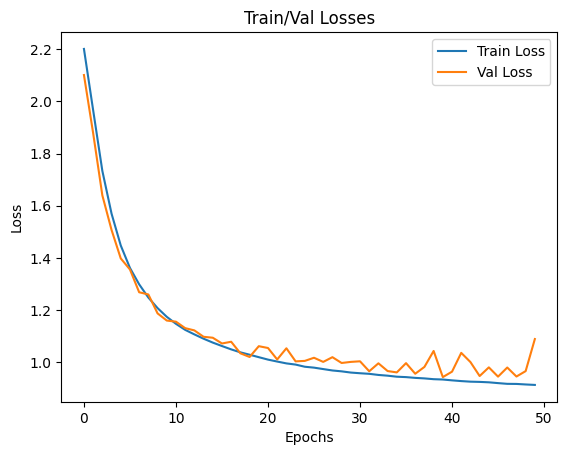

Training with lr=0.0001, wd=0.0001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 1832/1832 [00:05<00:00, 342.48it/s]


Epoch [1/50], Train Loss: 2.1979, Train Acc: 20.77%, Val Loss: 2.0869, Val Acc: 24.65%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 322227


100%|██████████| 1832/1832 [00:05<00:00, 353.49it/s]


Epoch [2/50], Train Loss: 1.8704, Train Acc: 36.45%, Val Loss: 1.7210, Val Acc: 44.89%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 264.25it/s]


Epoch [3/50], Train Loss: 1.6083, Train Acc: 47.54%, Val Loss: 1.5281, Val Acc: 49.82%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 343.50it/s]


Epoch [4/50], Train Loss: 1.4548, Train Acc: 53.52%, Val Loss: 1.3969, Val Acc: 56.08%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 456215


100%|██████████| 1832/1832 [00:05<00:00, 340.36it/s]


Epoch [5/50], Train Loss: 1.3461, Train Acc: 58.07%, Val Loss: 1.3011, Val Acc: 60.20%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 270.69it/s]


Epoch [6/50], Train Loss: 1.2680, Train Acc: 61.37%, Val Loss: 1.2338, Val Acc: 62.93%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 234995


100%|██████████| 1832/1832 [00:05<00:00, 316.87it/s]


Epoch [7/50], Train Loss: 1.2106, Train Acc: 63.36%, Val Loss: 1.1943, Val Acc: 64.35%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 380116


100%|██████████| 1832/1832 [00:05<00:00, 349.88it/s]


Epoch [8/50], Train Loss: 1.1703, Train Acc: 64.49%, Val Loss: 1.1799, Val Acc: 64.95%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 316043


100%|██████████| 1832/1832 [00:06<00:00, 272.20it/s]


Epoch [9/50], Train Loss: 1.1380, Train Acc: 65.62%, Val Loss: 1.1254, Val Acc: 66.62%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 34917


100%|██████████| 1832/1832 [00:05<00:00, 347.09it/s]


Epoch [10/50], Train Loss: 1.1102, Train Acc: 66.47%, Val Loss: 1.1059, Val Acc: 66.86%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 11765


100%|██████████| 1832/1832 [00:06<00:00, 267.98it/s]


Epoch [11/50], Train Loss: 1.0858, Train Acc: 67.34%, Val Loss: 1.0758, Val Acc: 67.86%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 235798


100%|██████████| 1832/1832 [00:06<00:00, 292.36it/s]


Epoch [12/50], Train Loss: 1.0670, Train Acc: 68.00%, Val Loss: 1.0596, Val Acc: 68.56%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 378200


100%|██████████| 1832/1832 [00:05<00:00, 350.83it/s]


Epoch [13/50], Train Loss: 1.0489, Train Acc: 68.62%, Val Loss: 1.0664, Val Acc: 67.61%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 283.31it/s]


Epoch [14/50], Train Loss: 1.0303, Train Acc: 69.11%, Val Loss: 1.0287, Val Acc: 69.38%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 23212


100%|██████████| 1832/1832 [00:06<00:00, 284.50it/s]


Epoch [15/50], Train Loss: 1.0160, Train Acc: 69.49%, Val Loss: 1.0361, Val Acc: 68.97%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 12003


100%|██████████| 1832/1832 [00:05<00:00, 348.67it/s]


Epoch [16/50], Train Loss: 1.0035, Train Acc: 69.87%, Val Loss: 0.9996, Val Acc: 70.52%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 9518


100%|██████████| 1832/1832 [00:05<00:00, 335.55it/s]


Epoch [17/50], Train Loss: 0.9905, Train Acc: 70.27%, Val Loss: 1.0767, Val Acc: 67.52%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 38183


100%|██████████| 1832/1832 [00:06<00:00, 268.19it/s]


Epoch [18/50], Train Loss: 0.9782, Train Acc: 70.69%, Val Loss: 1.0094, Val Acc: 70.11%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 109745


100%|██████████| 1832/1832 [00:05<00:00, 354.84it/s]


Epoch [19/50], Train Loss: 0.9663, Train Acc: 71.08%, Val Loss: 1.0439, Val Acc: 68.75%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 271.93it/s]


Epoch [20/50], Train Loss: 0.9571, Train Acc: 71.26%, Val Loss: 0.9821, Val Acc: 71.10%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 14203


100%|██████████| 1832/1832 [00:05<00:00, 321.34it/s]


Epoch [21/50], Train Loss: 0.9445, Train Acc: 71.65%, Val Loss: 0.9789, Val Acc: 71.04%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 35668


100%|██████████| 1832/1832 [00:05<00:00, 354.04it/s]


Epoch [22/50], Train Loss: 0.9354, Train Acc: 71.98%, Val Loss: 1.0014, Val Acc: 70.18%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 492425


100%|██████████| 1832/1832 [00:06<00:00, 281.47it/s]


Epoch [23/50], Train Loss: 0.9273, Train Acc: 72.16%, Val Loss: 0.9560, Val Acc: 71.49%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 277.79it/s]


Epoch [24/50], Train Loss: 0.9187, Train Acc: 72.56%, Val Loss: 0.9665, Val Acc: 71.70%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 340.16it/s]


Epoch [25/50], Train Loss: 0.9099, Train Acc: 72.82%, Val Loss: 0.9457, Val Acc: 72.19%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 38798


100%|██████████| 1832/1832 [00:06<00:00, 274.01it/s]


Epoch [26/50], Train Loss: 0.9027, Train Acc: 73.10%, Val Loss: 0.9217, Val Acc: 73.20%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 35973


100%|██████████| 1832/1832 [00:06<00:00, 294.76it/s]


Epoch [27/50], Train Loss: 0.8944, Train Acc: 73.34%, Val Loss: 0.9126, Val Acc: 73.43%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 561390


100%|██████████| 1832/1832 [00:05<00:00, 353.70it/s]


Epoch [28/50], Train Loss: 0.8877, Train Acc: 73.46%, Val Loss: 0.9228, Val Acc: 72.95%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 380058


100%|██████████| 1832/1832 [00:06<00:00, 274.86it/s]


Epoch [29/50], Train Loss: 0.8807, Train Acc: 73.71%, Val Loss: 0.9127, Val Acc: 73.51%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 325.75it/s]


Epoch [30/50], Train Loss: 0.8750, Train Acc: 73.77%, Val Loss: 0.9064, Val Acc: 73.68%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 593245


100%|██████████| 1832/1832 [00:05<00:00, 349.17it/s]


Epoch [31/50], Train Loss: 0.8698, Train Acc: 73.98%, Val Loss: 0.8822, Val Acc: 74.41%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:08<00:00, 223.29it/s]


Epoch [32/50], Train Loss: 0.8647, Train Acc: 74.30%, Val Loss: 0.9003, Val Acc: 73.42%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 741930


100%|██████████| 1832/1832 [00:05<00:00, 342.01it/s]


Epoch [33/50], Train Loss: 0.8570, Train Acc: 74.36%, Val Loss: 0.9001, Val Acc: 73.83%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 730096


100%|██████████| 1832/1832 [00:05<00:00, 324.49it/s]


Epoch [34/50], Train Loss: 0.8523, Train Acc: 74.54%, Val Loss: 0.9068, Val Acc: 73.47%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 39244


100%|██████████| 1832/1832 [00:06<00:00, 267.04it/s]


Epoch [35/50], Train Loss: 0.8482, Train Acc: 74.74%, Val Loss: 0.8909, Val Acc: 74.13%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 457642


100%|██████████| 1832/1832 [00:05<00:00, 327.65it/s]


Epoch [36/50], Train Loss: 0.8433, Train Acc: 74.69%, Val Loss: 0.8805, Val Acc: 74.40%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 109383


100%|██████████| 1832/1832 [00:05<00:00, 343.07it/s]


Epoch [37/50], Train Loss: 0.8380, Train Acc: 75.12%, Val Loss: 0.8611, Val Acc: 74.80%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 13000


100%|██████████| 1832/1832 [00:07<00:00, 261.14it/s]


Epoch [38/50], Train Loss: 0.8334, Train Acc: 75.10%, Val Loss: 0.9154, Val Acc: 72.85%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 292.56it/s]


Epoch [39/50], Train Loss: 0.8300, Train Acc: 75.23%, Val Loss: 0.8393, Val Acc: 76.02%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 454664


100%|██████████| 1832/1832 [00:05<00:00, 324.33it/s]


Epoch [40/50], Train Loss: 0.8258, Train Acc: 75.40%, Val Loss: 0.8464, Val Acc: 75.61%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 234531


100%|██████████| 1832/1832 [00:05<00:00, 337.71it/s]


Epoch [41/50], Train Loss: 0.8217, Train Acc: 75.45%, Val Loss: 0.9388, Val Acc: 72.30%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 309030


100%|██████████| 1832/1832 [00:07<00:00, 241.57it/s]


Epoch [42/50], Train Loss: 0.8194, Train Acc: 75.68%, Val Loss: 0.8979, Val Acc: 73.80%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 538670


100%|██████████| 1832/1832 [00:06<00:00, 269.11it/s]


Epoch [43/50], Train Loss: 0.8156, Train Acc: 75.75%, Val Loss: 0.8838, Val Acc: 73.81%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:05<00:00, 352.72it/s]


Epoch [44/50], Train Loss: 0.8128, Train Acc: 75.80%, Val Loss: 0.9065, Val Acc: 73.20%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 22047


100%|██████████| 1832/1832 [00:06<00:00, 270.52it/s]


Epoch [45/50], Train Loss: 0.8083, Train Acc: 76.00%, Val Loss: 0.8457, Val Acc: 75.60%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 311937


100%|██████████| 1832/1832 [00:05<00:00, 333.35it/s]


Epoch [46/50], Train Loss: 0.8049, Train Acc: 75.90%, Val Loss: 0.8225, Val Acc: 76.35%


Validating gradient for: model.fc1.weight
Validating gradient for: model.fc1.bias
Validating gradient for: model.fc2.weight
Validating gradient for: model.fc2.bias
Gradient check passed successfully!


100%|██████████| 1832/1832 [00:06<00:00, 277.73it/s]


Epoch [47/50], Train Loss: 0.8028, Train Acc: 76.13%, Val Loss: 0.8804, Val Acc: 74.21%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 107913


100%|██████████| 1832/1832 [00:05<00:00, 315.45it/s]


Epoch [48/50], Train Loss: 0.8004, Train Acc: 76.00%, Val Loss: 0.8381, Val Acc: 75.76%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 312801


100%|██████████| 1832/1832 [00:06<00:00, 275.97it/s]


Epoch [49/50], Train Loss: 0.7973, Train Acc: 76.23%, Val Loss: 0.8568, Val Acc: 74.97%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 542548


100%|██████████| 1832/1832 [00:06<00:00, 278.06it/s]


Epoch [50/50], Train Loss: 0.7939, Train Acc: 76.44%, Val Loss: 0.8465, Val Acc: 75.31%


Validating gradient for: model.fc1.weight
Gradient check failed for model.fc1.weight at index 12534


100%|██████████| 3254/3254 [00:09<00:00, 342.39it/s]


Test Accuracy with learning rate 0.0001 and weight_decay 0.0001: 72.58%


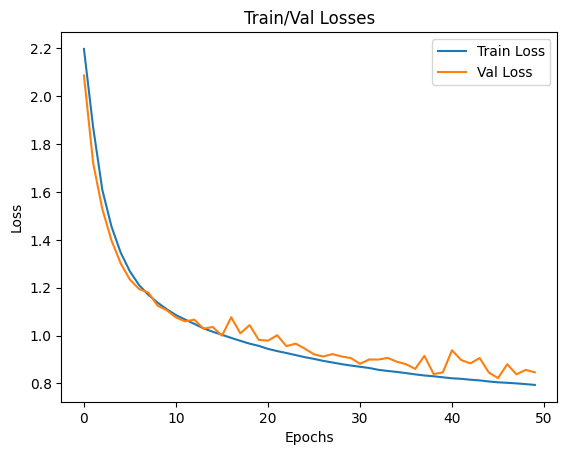

,optimizer,learning_rate,weight_decay,val_accuracy
0,RMSprop,0.0001,0.0100,0.633497
0,RMSprop,0.0001,0.0010,0.727204
0,RMSprop,0.0001,0.0001,0.763514


In [16]:
train_grid_search(results, 50, [0.0001], [0.01, 0.001, 0.0001])

## Результаты

Наибольшее значение accuracy=72.58% на тестовой выборке получено при learning_rate=0.0001 и weight_decay=0.0001 с использованием оптимизатора RMSprop.